# Assignment 2 - Prediction.ipynb
# This is the only notebook file with new code in it
# The other two files are duplicates from Assignment 1

In [18]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import shapefile
from descartes import PolygonPatch
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
from time import time
import statsmodels.api as sm

from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor


SMALL, MED, LARGE = 18, 24, 30
LW = 2
plt.rc('xtick',labelsize=SMALL)
plt.rc('ytick',labelsize=SMALL)

# RMSE used instead of MAE since we want to punish really bad errors more than small errors
def RMSE(yhat, y):
    return np.sqrt(mean_squared_error(np.e**(np.array(yhat)), np.e**(np.array(y))))

## Firstly, some assignment 2 specific preprocessing

In [2]:
%%time
# Run as "True" first time only - Takes around 1 min
if 0:
    taxi = pd.read_pickle(f'../Ass1/taxi-data/yellow_tripdata_all.pkl')

    taxi['year'] = taxi.tpep_pickup_datetime.dt.year
    taxi['month'] = taxi.tpep_pickup_datetime.dt.month
    taxi['date'] = taxi.tpep_pickup_datetime.dt.date
    taxi['day'] = taxi.tpep_pickup_datetime.dt.weekday
    taxi['hour'] = taxi.tpep_pickup_datetime.dt.hour
    
    taxi = taxi[taxi.year == 2020]

    # Vehicle type not recorded, so fuel consumption cannot be calculated, so ignoring that, we calculate profit
    # Taxis do not get MTA commuters tax, improvement_surcharge also goes straight to paying for driver disability training,
    # So not included in profit either. Congestion surcharge is also tax for trips that begin and end in NYC
    # Extra column appears to be surcharges and other extras that are not for profit
    taxi['profit'] = taxi.fare_amount + taxi.tip_amount

    taxi['profitph'] = taxi.profit / taxi.duration
    #taxi['profitph2'] = (taxi.profit - 10 - 5*taxi.duration) / (taxi.duration + 0.5)

    taxi = taxi[['PULocationID', 'month', 'date', 'day', 'hour', 'profitph']]
    
    covid = pd.read_csv('../Ass1/coronavirus-data/case-hosp-death.csv')
    covid.columns = ['date', 'cases', 'hosps', 'deaths']
    covid.date = pd.to_datetime(covid.date)
    
    taxi['date'] = taxi['date'].astype(str)
    covid['date'] = covid['date'].astype(str)

    taxi = taxi.merge(covid, on='date', how='inner').drop('date', axis=1)
    
    for col in ['cases', 'hosps', 'deaths']:
        taxi[col] = taxi[col].fillna(0)
        
    # Converting to int reduced file sizes by 47.62% i.e. 3.226 GB to 1.690 GB
    for col in ['PULocationID', 'month', 'day', 'hour', 'cases', 'hosps', 'deaths']:
        taxi[col] = taxi[col].astype(int)
        
    # Set seed to always get same split
    np.random.seed(0)

    # Shuffle data (taxi.sample(frac=1)), then split into train, validate, test split 50:25:25
    train, val, test = np.split(taxi.sample(frac=1), [int(.5*len(taxi)), int(.75*len(taxi))])

    print(f'len(train): {len(train)}, len(val): {len(val)}, len(test): {len(test)}')
    
    train.to_pickle('train.pkl')
    val.to_pickle('val.pkl')
    test.to_pickle('test.pkl')

Wall time: 0 ns


## Descriptive stats for attributes. Graph each one

## Write Research Goal

## Investigate pairwise relationship between attributes

### Only using train data to do this preprocessing to avoid data leakage

Excluded month since we don't have that for the next month

In [3]:
train = pd.read_pickle('train.pkl')
val   = pd.read_pickle('val.pkl')
test  = pd.read_pickle('test.pkl')

train.head(5)

,PULocationID,month,day,hour,profitph,cases,hosps,deaths
1119272,237,3,5,18,101.784173,7,15,0
450322,237,3,1,13,76.008403,2,20,0
2351001,143,5,3,15,75.506087,641,140,38
1898980,158,3,5,22,50.791889,644,159,2
1990440,90,3,1,13,75.761194,2455,359,8


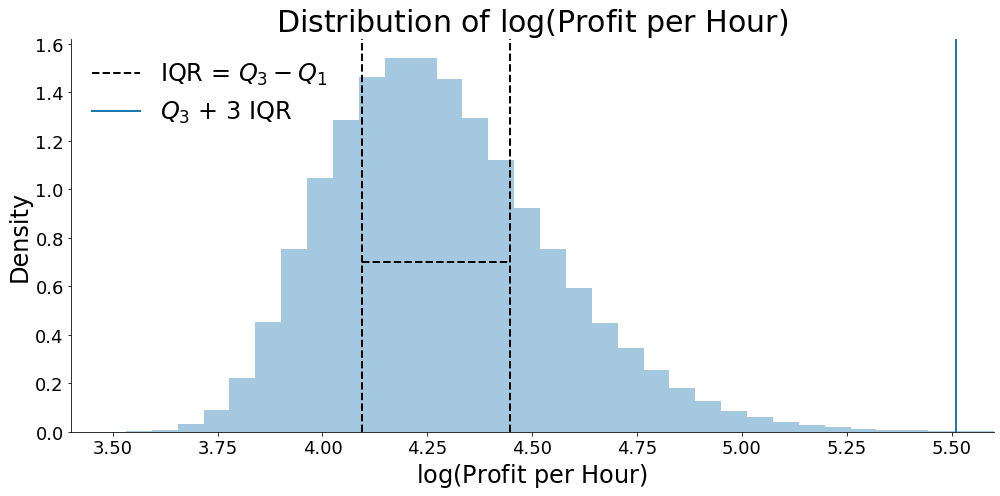

In [4]:
fig, ax = plt.subplots(figsize=(14, 7))

log_profitph = np.log(train.profitph)

# Calculate and plot common outlier thresholds. These are appropriate because log(profitph) is approximately normal
Q1, Q3 = np.quantile(log_profitph, 0.25), np.quantile(log_profitph, 0.75)
IQR = Q3 - Q1 
extreme_outlier = Q3 + 3*IQR

# We will exclude all outlier to the right of 3*IQR
plt.axvline(extreme_outlier)
sns.distplot(log_profitph[log_profitph<=6], kde=False, ax=ax, norm_hist=True)
plt.axvline(Q1, c='black', lw=LW, linestyle='--')
plt.axvline(Q3, c='black', lw=LW, linestyle='--')

x1, y1 = [Q1, Q3], [0.7, 0.7]
plt.plot(x1, y1, label='IQR = $Q_3-Q_1$', c='black', linestyle='--', lw=LW)

plt.axvline(extreme_outlier, label='$Q_3$ + 3 IQR', lw=LW)

ax.set_title('Distribution of $\log$(Profit per Hour)', fontsize=LARGE)
ax.set_xlabel('$\log$(Profit per Hour)', fontsize=MED)
ax.set_ylabel('Density',fontsize=MED)

plt.legend(frameon=False, fontsize=MED)
ax.set_xlim(3.4, 5.6)
sns.despine()
plt.tight_layout()
plt.savefig('Distribution of log profitph.png', dpi=fig.dpi*2, bbox_inches='tight')
plt.show()

In [5]:
Q1, Q3

(4.09380093622339, 4.447683389638823)

In [7]:
train['PULocationID'].value_counts()

236    58874
237    57296
161    49519
162    46797
186    43916
       ...  
46         1
6          1
27         1
109        1
2          1
Name: PULocationID, Length: 250, dtype: int64

In [28]:
# Keep pick up locations that appear in more than 1% of train rows
loc_counts = pd.DataFrame(train['PULocationID'].value_counts())
keep = loc_counts[loc_counts['PULocationID'] > len(train)/100].index

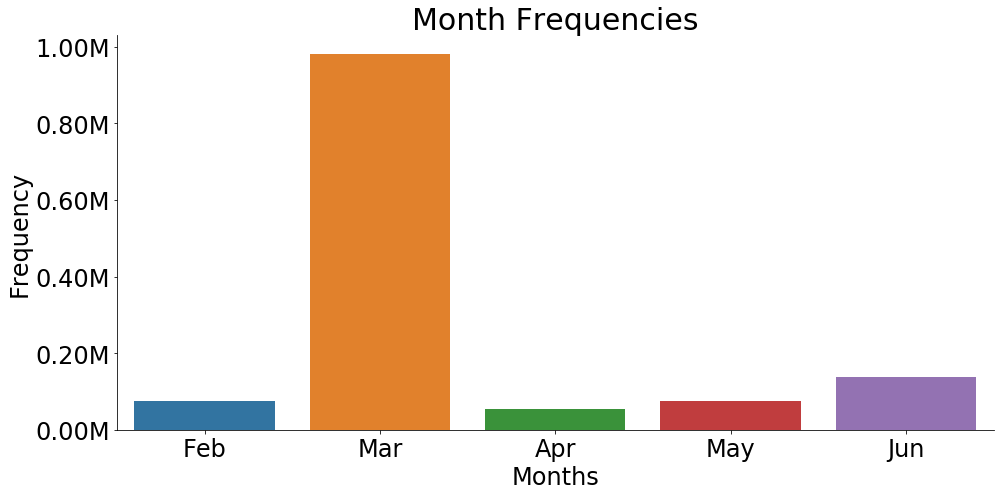

In [13]:
fig, ax = plt.subplots(figsize=(14, 7))

g = sns.countplot(train.month, ax=ax)

ax.set_title('Month Frequencies', fontsize=LARGE)
ax.set_xlabel('Months', fontsize=MED)
ax.set_ylabel('Frequency',fontsize=MED)
ax.set_xticklabels(['Feb', 'Mar', 'Apr', 'May', 'Jun'])

ylabels = ['{:,.2f}'.format(y/1_000_000) + 'M' for y in g.get_yticks()]
g.set_yticklabels(ylabels)

sns.despine()
plt.tight_layout()
plt.savefig('Month Frequencies.png', dpi=fig.dpi*2, bbox_inches='tight')
plt.show()

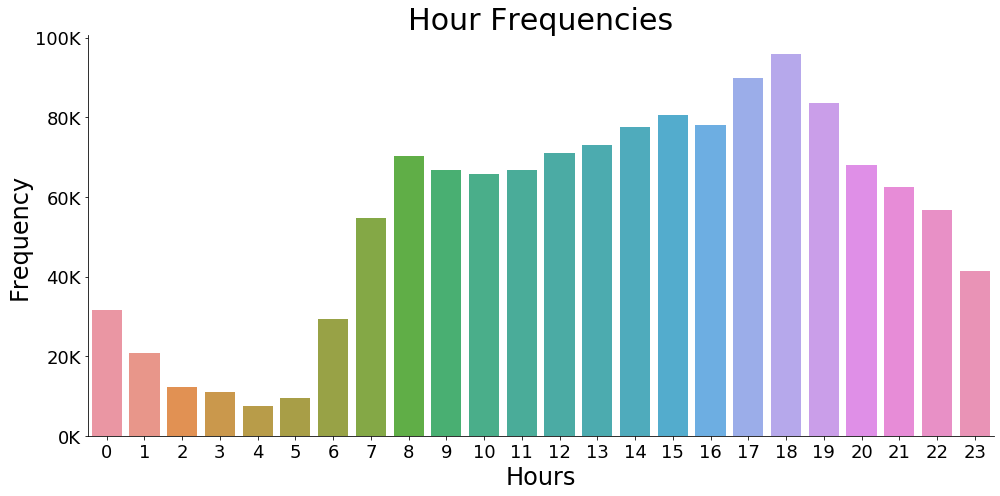

In [8]:
fig, ax = plt.subplots(figsize=(14, 7))

g = sns.countplot(train.hour, ax=ax)

ax.set_title('Hour Frequencies', fontsize=LARGE)
ax.set_xlabel('Hours', fontsize=MED)
ax.set_ylabel('Frequency',fontsize=MED)

ylabels = [str(int(y/1000)) + 'K' for y in g.get_yticks()]
g.set_yticklabels(ylabels)

sns.despine()
plt.tight_layout()
plt.savefig('Hour Frequencies.png', dpi=fig.dpi*2, bbox_inches='tight')
plt.show()

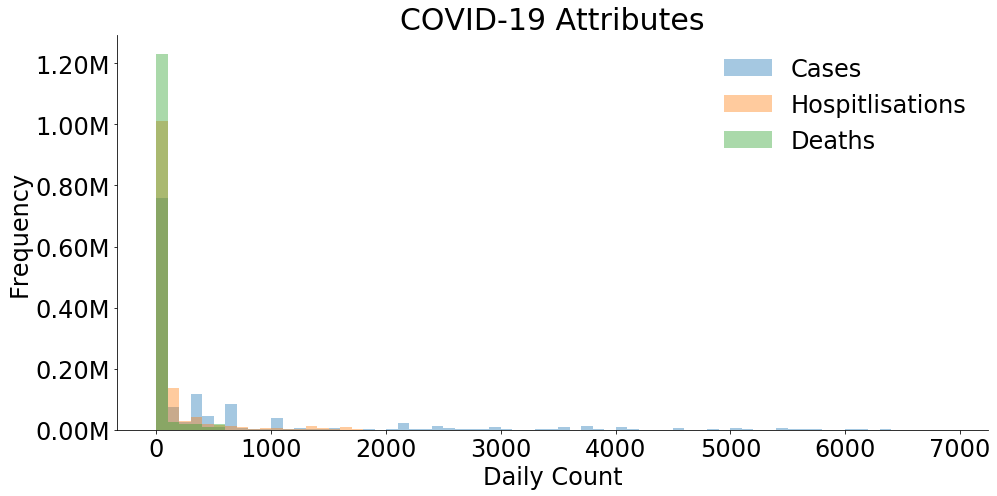

In [14]:
# Skew alone is not enough reason to justify log transform
fig, ax = plt.subplots(figsize=(14, 7))

g = sns.distplot(train.cases, ax=ax, kde=False, bins=np.arange(0, 7000, 100), label='Cases')
sns.distplot(train.hosps,     ax=ax, kde=False, bins=np.arange(0, 7000, 100), label='Hospitlisations')
sns.distplot(train.deaths,    ax=ax, kde=False, bins=np.arange(0, 7000, 100), label='Deaths')

ax.set_title('COVID-19 Attributes', fontsize=LARGE)
ax.set_xlabel('Daily Count', fontsize=MED)
ax.set_ylabel('Frequency',fontsize=MED)

ylabels = ['{:,.2f}'.format(y/1_000_000) + 'M' for y in g.get_yticks()]
g.set_yticklabels(ylabels)

plt.legend(frameon=False, fontsize=MED)
sns.despine()
plt.tight_layout()
plt.savefig('Covid19.png', dpi=fig.dpi*2, bbox_inches='tight')
plt.show()

In [8]:
train.cases.median(), train.hosps.median(), train.deaths.median()

(58.0, 37.0, 0.0)

In [10]:
train.columns

Index(['PULocationID', 'month', 'day', 'hour', 'profitph', 'cases', 'hosps',
       'deaths'],
      dtype='object')

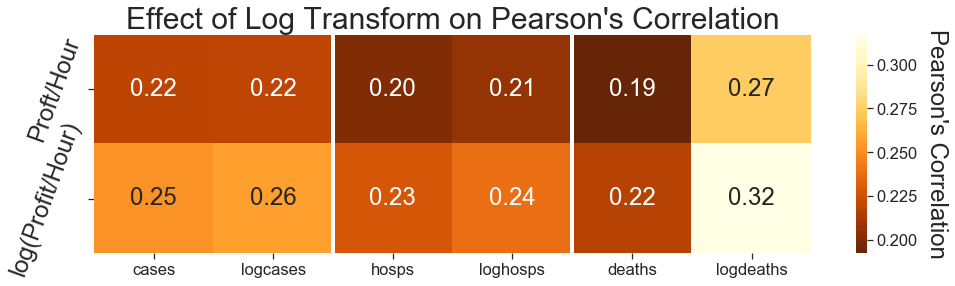

In [29]:
# Improves r2, and should have no effect on xgboost trees since it's monotonic transform
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

train['logprofitph'] = np.log(train.profitph)
train['logcases'] = np.log(train.cases + 1)
train['loghosps'] = np.log(train.hosps + 1)
train['logdeaths'] = np.log(train.deaths + 1)

train = train[['PULocationID', 'month', 'day', 'hour', 
               'cases', 'logcases', 'hosps', 'loghosps', 'deaths', 'logdeaths', 'profitph', 'logprofitph']]

fig, ax = plt.subplots(figsize=(14.2, 4.3))
sns.heatmap(train.drop(['month', 'PULocationID', 'month', 'day', 'hour'], axis=1).corr().iloc[-2:, :-2], 
            ax=ax, annot=True, fmt='.2f', annot_kws={"fontsize":MED}, cmap='YlOrBr_r')

ax.set_title("Effect of Log Transform on Pearson's Correlation", fontsize=LARGE)

cbar = ax.collections[0].colorbar
cbar.set_label("Pearson's Correlation", fontsize=MED, rotation=270, labelpad=30)

plt.yticks(np.arange(2)+0.5,('Proft/Hour', 'log(Profit/Hour)'), rotation=70, fontsize=MED, va="center")
plt.tight_layout()
plt.axvline(2, c='white', lw=LW*2)
plt.axvline(4, c='white', lw=LW*2)
plt.savefig('Log Transform.png', dpi=fig.dpi*2, bbox_inches='tight')
plt.show()

In [36]:
def final_preprocess(data):
    # Remove outliers 
    data = data[np.log(data.profitph) <= extreme_outlier]
    
    # Group rare locations
    data['PULocationID'] = np.where(data.PULocationID.isin(keep), data.PULocationID, 'other')
    
    # Log transformations
    data['logprofitph'] = np.log(data.profitph)
    data['logcases']  = np.log(data.cases  + 1)
    data['loghosps']  = np.log(data.hosps  + 1)
    data['logdeaths'] = np.log(data.deaths + 1)
    
    data = data.drop(['profitph', 'month', 'cases', 'hosps', 'deaths'], axis=1)
    
    # Drop one of each "dummied" attribute values to avoid perfect multicollinearity (a.k.a. dummy variable trap)
    ohe = pd.get_dummies(data, columns=['day', 'hour', 'PULocationID']).drop([
          'day_0', 'hour_0', 'PULocationID_other', 'logprofitph'], axis=1)
    
    data['PULocationID'] = data.PULocationID.astype(str)
    data['day'] = data.day.astype(str)
    data['hour'] = data.hour.astype(str)
    
    # Train test split
    return data.drop('logprofitph', axis=1), ohe, data['logprofitph']

X_train, X_train_ohe, y_train = final_preprocess(train)
X_val,   X_val_ohe,   y_val   = final_preprocess(val)
X_test,  X_test_ohe,  y_test  = final_preprocess(test)

# Scale Data
sc = StandardScaler()
sc.fit(X_train_ohe)
X_train_ohe, X_val_ohe, X_test_ohe = sc.transform(X_train_ohe), sc.transform(X_val_ohe), sc.transform(X_test_ohe)

# PCA Transform
pca = PCA(n_components=10)
pca.fit(X_train_ohe)
pcaX_train_ohe, pcaX_val_ohe, pcaX_test_ohe = pca.transform(X_train_ohe), pca.transform(X_val_ohe), pca.transform(X_test_ohe)

X_train_ohe.shape, X_val_ohe.shape, X_test_ohe.shape

((1323112, 70), (661554, 70), (661523, 70))

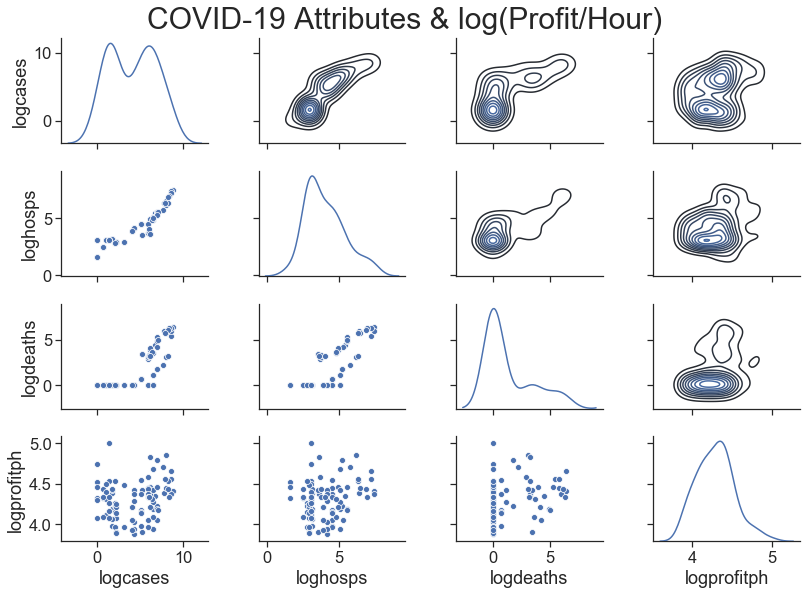

In [21]:
sns.set(font_scale=1.5)

with sns.axes_style("ticks"):
    g = sns.PairGrid(train[train.profitph <= 200][['logcases', 'loghosps', 'logdeaths', 'logprofitph']].sample(100),
                 diag_sharey=False)

g.fig.suptitle('COVID-19 Attributes & log(Profit/Hour)', fontsize=LARGE, y=1.02)
g.map_lower(sns.scatterplot)
g.map_upper(sns.kdeplot)
g.map_diag(sns.kdeplot)
g.fig.set_size_inches(12, 8)

#plt.tight_layout()
plt.savefig('Covid19 and logprofitph.png', dpi=fig.dpi*2, bbox_inches='tight')
plt.show()

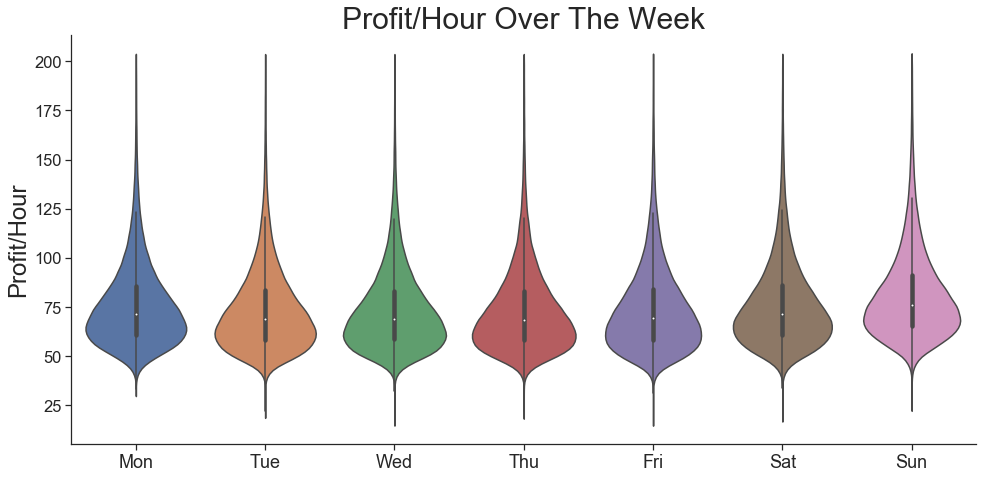

In [22]:
sns.set_style("ticks")

fig, ax = plt.subplots(figsize=(14, 7))
sns.violinplot(x=train[train.profitph <=200].day, y=train[train.profitph <=200].profitph, ax=ax)

ax.set_title('Profit/Hour Over The Week', fontsize=LARGE)
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=SMALL)
ax.set_ylabel('Profit/Hour', fontsize=MED)
ax.set_xlabel('')

plt.tight_layout()
sns.despine()
plt.savefig('profitph over week.png', dpi=fig.dpi*2, bbox_inches='tight')
plt.show()

In [44]:
train[train.profitph<= 200].groupby('day').mean()

,PULocationID,month,hour,cases,logcases,hosps,loghosps,deaths,logdeaths,profitph,logprofitph
day,,,,,,,,,,,
0,164.945721,3.520341,13.938854,642.328693,3.745725,153.650159,4.113739,31.918279,1.258122,76.093490,4.296952
1,166.248144,3.530808,14.095423,588.764786,3.961882,141.585230,4.069583,29.660856,1.162743,73.513993,4.261192
2,165.535513,3.466475,14.155598,604.514092,4.322890,152.601044,4.189456,32.080544,1.356983,73.417220,4.260354
3,165.569052,3.479739,14.073422,637.281185,4.260101,146.574636,4.089147,30.778976,1.085178,73.165728,4.256394
4,163.958123,3.571567,13.939868,734.365262,4.702709,174.610100,4.177092,37.203683,1.277216,73.930862,4.264764
5,161.340236,2.973981,13.847978,293.063540,2.928249,90.389505,3.361809,21.436687,0.870725,76.451214,4.300596
6,159.013717,3.364674,12.578638,305.546680,2.948139,86.997404,3.063644,23.209011,0.956741,81.136133,4.362530


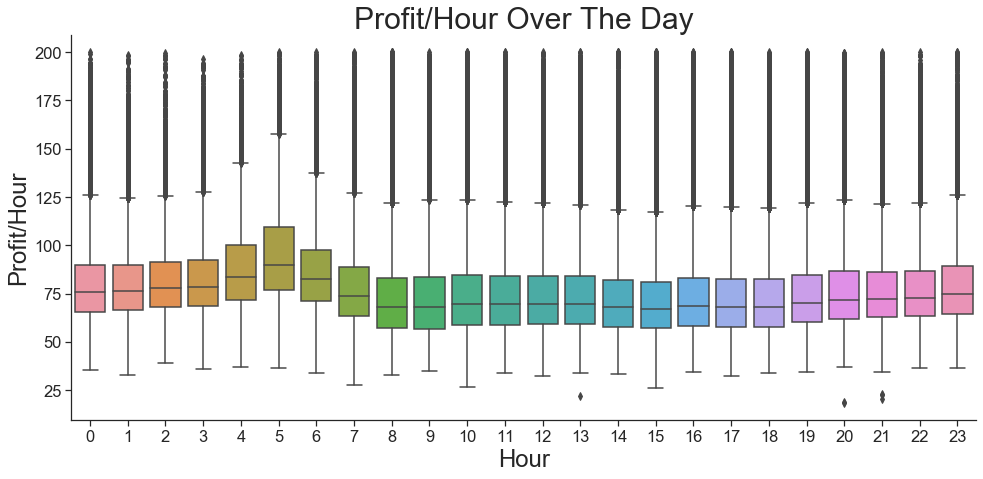

In [19]:
sns.set_style("ticks")
fig, ax = plt.subplots(figsize=(14, 7))
sns.boxplot(x=train[train.profitph <=200].hour, y=train[train.profitph <=200].profitph, ax=ax)

ax.set_title('Profit/Hour Over The Day', fontsize=LARGE)
ax.set_ylabel('Profit/Hour', fontsize=MED)
ax.set_xlabel('Hour', fontsize=MED)

plt.tight_layout()
sns.despine()
plt.savefig('profitph over day.png', dpi=fig.dpi*2, bbox_inches='tight')
plt.show()

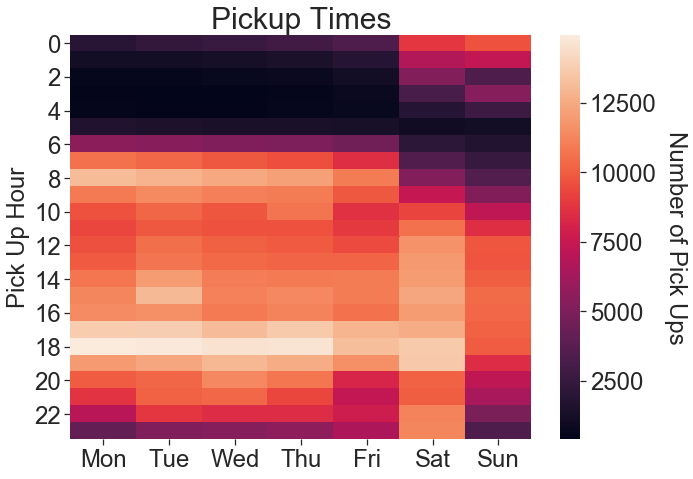

In [25]:
fig, ax = plt.subplots(figsize=(10, 7))

sns.heatmap(pd.DataFrame(train.groupby(['day', 'hour']).size()).unstack().T, ax=ax)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=MED)
cbar.set_label('Number of Pick Ups', fontsize=MED, rotation=270, labelpad=30)
ax.set_title('Pickup Times', fontsize=LARGE)
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], fontsize=MED)
ax.set_yticklabels([i for i in range(24) if (i+1)%2], rotation=0, fontsize=MED)
ax.set_ylabel('Pick Up Hour', fontsize=MED)
ax.set_xlabel('')

plt.tight_layout()
plt.savefig('pickup times.png', dpi=fig.dpi*2, bbox_inches='tight')
plt.show()

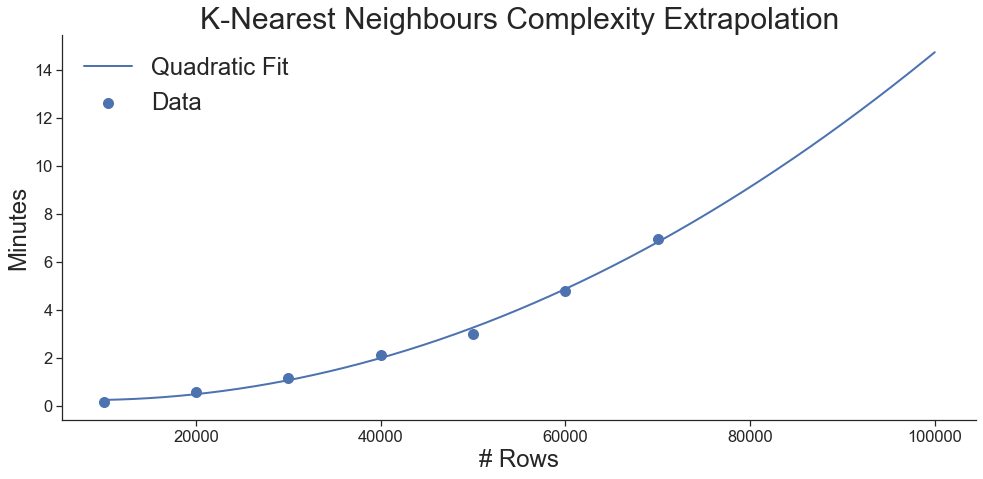

This implies that it would take 49.45 mins to fit and predict all of the training data
Meanwhile, with the first principal component, it only takes 30s to fit and predict


In [36]:
# Estimated to take 40 mins
ns = np.arange(10_000, 70_001, 10_000)
if 0:
    ts = []

    for n in tqdm(ns):
        t0 = time()

        knn = KNeighborsRegressor()
        knn.fit(X_train_ohe[:n], y_train[:n])
        mse = MSE(y_train[:n], knn.predict(X_train_ohe[:n]))

        t1 = time()

        ts.append(t1 - t0)

fig, ax = plt.subplots(figsize=(14, 7))

ax.scatter(ns, np.array(ts)/60, label='Data', s=100)

x = np.linspace(10_000, 100_000, 1_000)
# Calculated quadratic fit externally
y = 1.7127*10**(-9)*x**2 - 0.0000274086*x + 0.342324
ax.plot(x, y, label='Quadratic Fit', lw=LW)

ax.set_title('K-Nearest Neighbours Complexity Extrapolation', fontsize=LARGE)
ax.set_xlabel('# Rows', fontsize=MED)
ax.set_ylabel('Minutes',fontsize=MED)

plt.legend(frameon=False, fontsize=MED)
sns.despine()
plt.tight_layout()
plt.show()

print(f'This implies that it would take ' +
      f'{round((1.7127*10**(-9)*len(train)**2 - 0.0000274086*len(train) + 0.342324)/60, 2)} mins '+
      f'to fit and predict all of the training data')
print('Meanwhile, with the first principal component, it only takes 30s to fit and predict')

In [ ]:
%%time
# PCA makes training and predicting quicker
if 0:
    nn = MLPRegressor()
    nn.fit(X_train_ohe, y_train)
    nn.predict(X_train_ohe)
print('2min 25s')

In [ ]:
%%time
if 0:
    nn = MLPRegressor()
    nn.fit(pcaX_train_ohe, y_train)
    nn.predict(pcaX_train_ohe)
print('1min 35s')

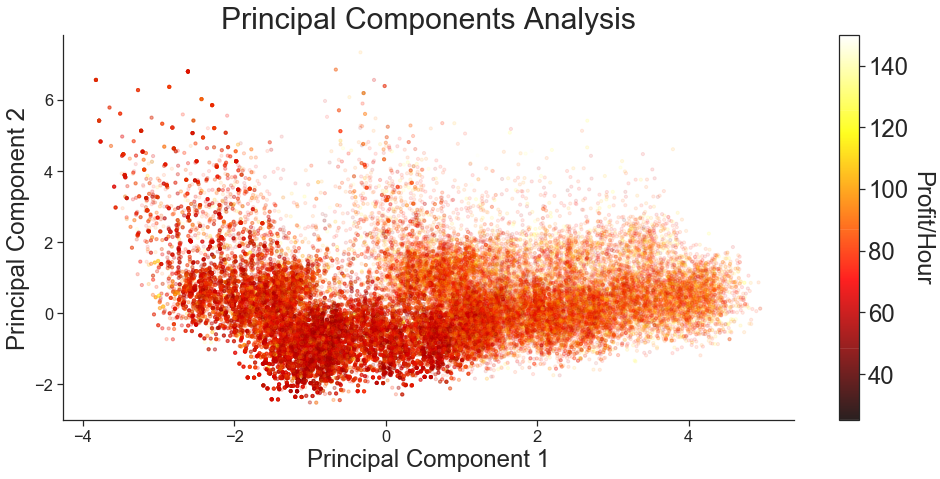

In [31]:
# PCA shows promising results
fig, ax = plt.subplots(figsize=(14, 7))
n=100_000
sc = ax.scatter(pcaX_train_ohe[:n,0], pcaX_train_ohe[:n,1], c=np.e**y_train.iloc[:n], alpha=0.1, s=10, 
                cmap='hot', vmin=25, vmax=150)
cbar = fig.colorbar(sc)
cbar.solids.set(alpha=0.4)
cbar.solids.set_edgecolor('face')
cbar.ax.tick_params(labelsize=MED)
cbar.set_label('Profit/Hour', rotation=270, fontsize=MED, labelpad=25)

ax.set_title('Principal Components Analysis', fontsize=LARGE)
ax.set_xlabel('Principal Component 1', fontsize=MED)
ax.set_ylabel('Principal Component 2',fontsize=MED)

sns.despine()
plt.tight_layout()
plt.savefig('PCA2.png', dpi=fig.dpi*2, bbox_inches='tight')
plt.show()

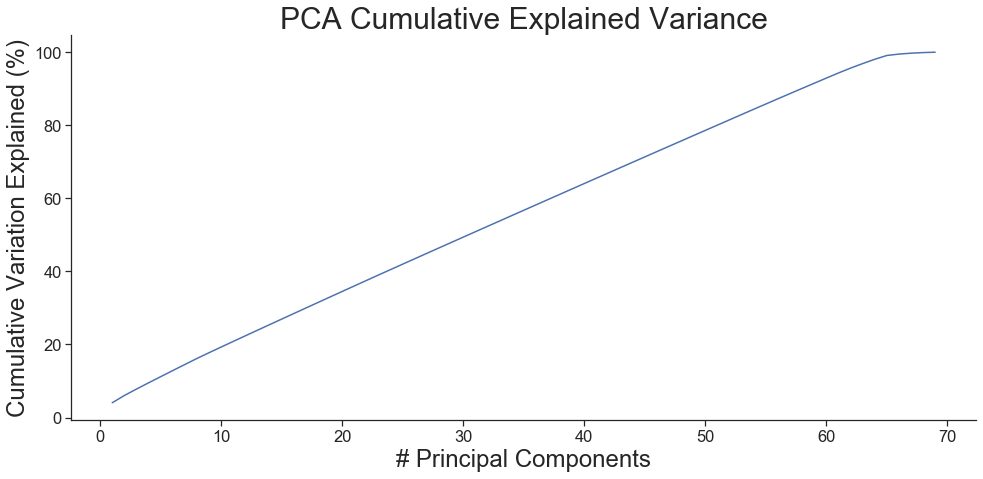

In [32]:
# However clearly isn't good enough since need essentially all principal components to explain all variance
pca2 = PCA(n_components=69)
pca2.fit(X_train_ohe)
pX_proj = pca2.transform(X_train_ohe)
pexplained_variances = np.var(pX_proj, axis=0) / np.var(X_train_ohe, axis=0).sum()

fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(1, 70, 1)
ax.plot(x, 100*np.cumsum(pexplained_variances), label='PCA')

ax.set_title('PCA Cumulative Explained Variance', fontsize=LARGE)
ax.set_xlabel('# Principal Components', fontsize=MED)
ax.set_ylabel('Cumulative Variation Explained (%)', fontsize=MED)

sns.despine()
plt.tight_layout()
plt.savefig('PCA CumVar.png', dpi=fig.dpi*2, bbox_inches='tight')
plt.show()

# Predictive Modelling

In [345]:
# Baseline 1
dummy = DummyRegressor(strategy="mean")
dummy.fit(X_train_ohe, y_train)
RMSE(dummy.predict(X_val_ohe), y_val)

22.472478019134233

In [ ]:
# Check multicollinearity with correlation matrix
# Check for independence of errors with residual / data order train_index
# Assume X is fixed and y is variable, fair enough assumption
# Residuals vs fitted to assess linearity - should be random

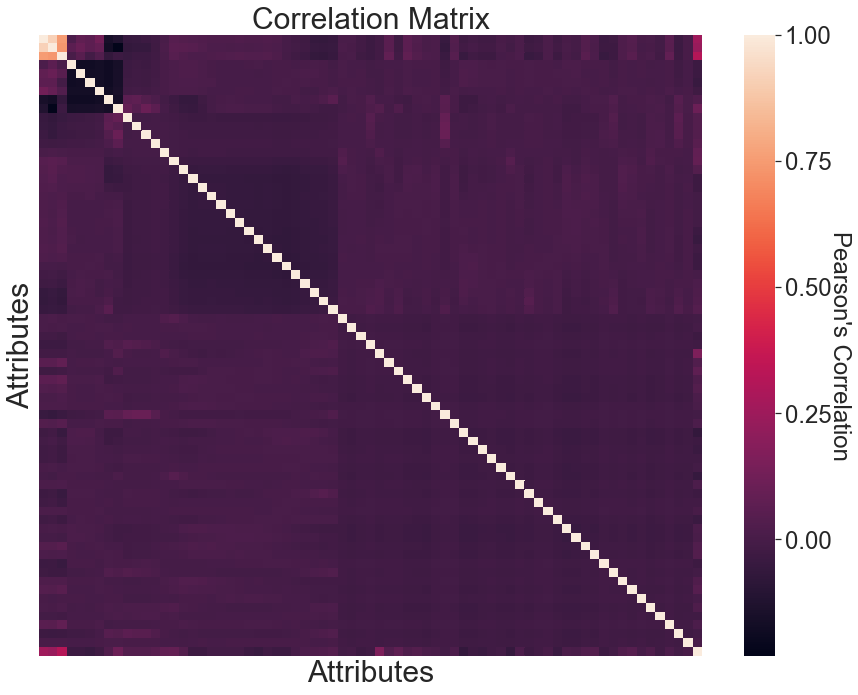

In [33]:
y = pd.DataFrame(y_train.to_numpy())
y.columns = ['-']

corrs = pd.concat([pd.DataFrame(X_train_ohe), y], axis=1).corr()

fig, ax = plt.subplots(figsize=(12.5, 10))

sns.heatmap(corrs, ax=ax)
ax.set_title('Correlation Matrix', fontsize=LARGE)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlabel('Attributes', fontsize=LARGE)
ax.set_ylabel('Attributes', fontsize=LARGE)

cbar = ax.collections[0].colorbar
cbar.set_label("Pearson's Correlation", fontsize=MED, rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=MED)
plt.tight_layout()
plt.savefig('corr.png', dpi=fig.dpi*2, bbox_inches='tight')
plt.show()

In [34]:
# Baseline 2
lm = LinearRegression()
lm.fit(pcaX_train_ohe,  y_train)
print(RMSE(lm.predict(pcaX_val_ohe), y_val))

# Baseline 2
lm = LinearRegression()
lm.fit(X_train_ohe, y_train)
print(RMSE(lm.predict(X_val_ohe), y_val))

21.23298530770718
20.21220241324288


In [37]:
X_train_sorted,  X_train_ohe_sorted,  y_train_sorted  = final_preprocess(train.sort_index())

# Scale Data
X_train_ohe_sorted = sc.transform(X_train_ohe_sorted)

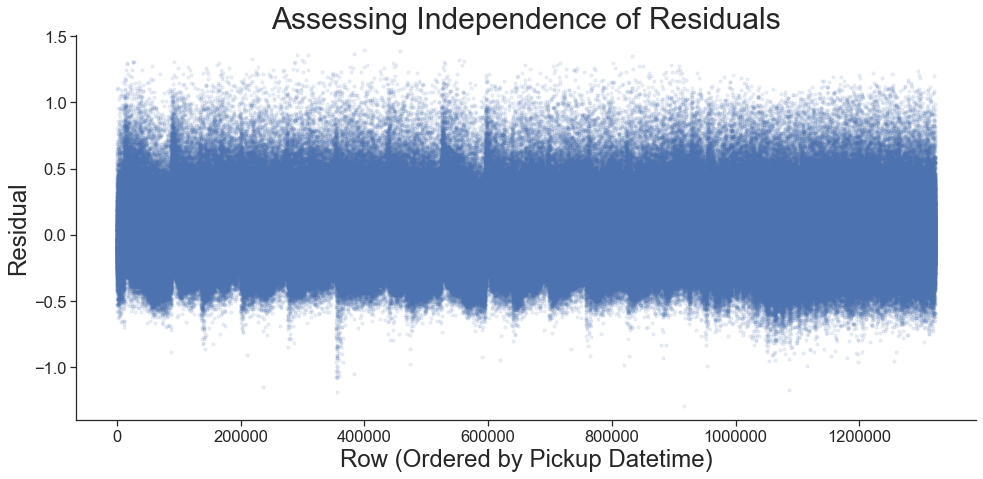

In [38]:
residuals = np.array(y_train_sorted) - lm.predict(X_train_ohe_sorted)

fig, ax = plt.subplots(figsize=(14, 7))
ax.scatter(np.arange(0, len(X_train_ohe_sorted)), residuals, s=10, alpha=0.1)

ax.set_title('Assessing Independence of Residuals', fontsize=LARGE)
ax.set_xlabel('Row (Ordered by Pickup Datetime)', fontsize=MED)
ax.set_ylabel('Residual', fontsize=MED)
plt.ylim(-1.4, 1.51)

sns.despine()
plt.tight_layout()
plt.savefig('residual independence.png', dpi=fig.dpi*2, bbox_inches='tight')
plt.show()

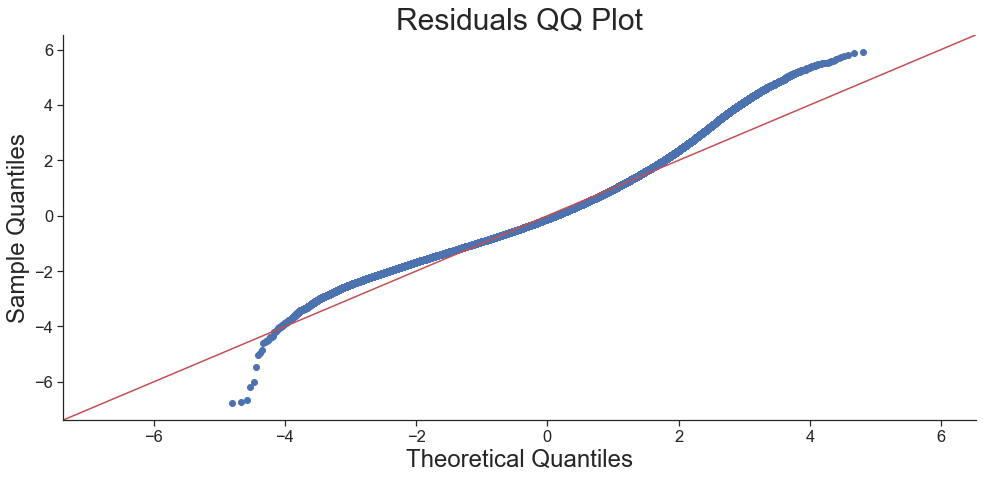

In [240]:
fig, ax = plt.subplots(figsize=(14, 7))

sm.qqplot((residuals - np.mean(residuals)) / np.std(residuals), line='45', ax=ax)
ax.set_title('Residuals QQ Plot', fontsize=LARGE)
ax.set_xlabel('Theoretical Quantiles', fontsize=MED)
ax.set_ylabel('Sample Quantiles', fontsize=MED)
sns.despine()
plt.tight_layout()
plt.savefig('QQ Plot.png', dpi=fig.dpi*2, bbox_inches='tight')
plt.show()

# We won't run any hypothesis tests as they can be unreliable 

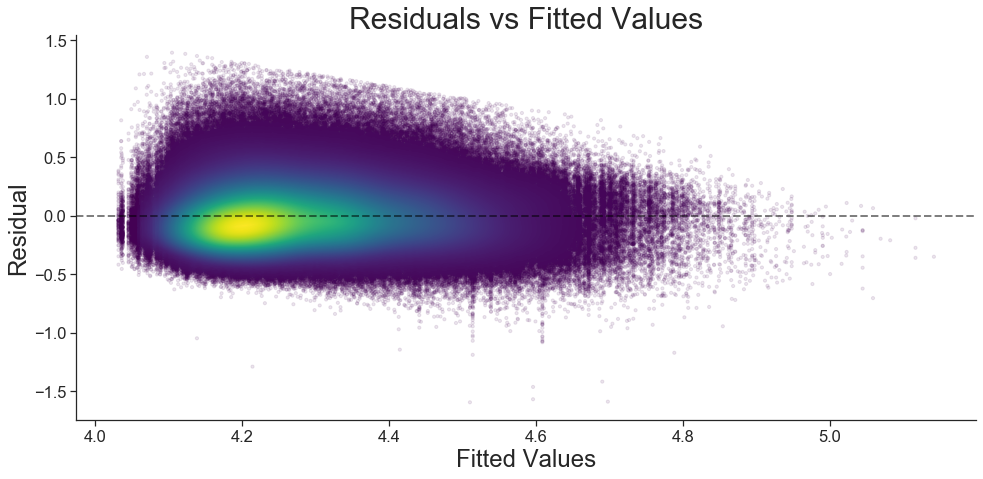

In [39]:
# https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib
fig, ax = plt.subplots(figsize=(14, 7))
x, y = lm.predict(X_train_ohe_sorted), residuals
data, x_e, y_e = np.histogram2d(x, y, bins=20, density=True)
z = interpn((0.5*(x_e[1:]+x_e[:-1]),0.5*(y_e[1:]+y_e[:-1])),data,np.vstack([x,y]).T,method="splinef2d",bounds_error=False)

#To be sure to plot all data
z[np.where(np.isnan(z))] = 0.0

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

ax.scatter(x, y, c=z, s=10, cmap='viridis', alpha=0.1)
plt.axhline(0, lw=LW, c='black', linestyle='--', alpha=0.5)

ax.set_title('Residuals vs Fitted Values', fontsize=LARGE)
ax.set_xlabel('Fitted Values', fontsize=MED)
ax.set_ylabel('Residual', fontsize=MED)

sns.despine()
plt.tight_layout()
plt.savefig('fitted vs residuals.png', dpi=fig.dpi*2, bbox_inches='tight')
plt.show()

In [9]:
from sklearn.model_selection import ParameterGrid
param_grid = {'hidden_layer_sizes': [(10, 10), (100, 10), (1000, 10)], 'batch_size': [10, 100], 
              'learning_rate_init':[0.1, 0.01, 0.001, 0.0001]}
params = ParameterGrid(param_grid)

if 0:
    # Takes 7hrs
    losses = []

    for param in tqdm(list(params)):
        hidden_layer_sizes = param['hidden_layer_sizes']
        batch_size = param['batch_size']
        learning_rate_init = param['learning_rate_init']

        nn = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, batch_size=batch_size, learning_rate_init=learning_rate_init,
                          max_iter=1000, random_state=0)

        nn.fit(X_train_ohe, y_train)
        losses.append(RMSE(nn.predict(X_val_ohe), y_val))
    
batch_sizes = []
hidden_layer_sizes = []
learning_rate_inits = []
for param in params:
    batch_sizes.append(param['batch_size'])
    hidden_layer_sizes.append(param['hidden_layer_sizes'])
    learning_rate_inits.append(param['learning_rate_init'])
    
results = pd.DataFrame({'batch_size': batch_sizes, 'hidden_layer_sizes': hidden_layer_sizes, 
                       'learning_rate_init': learning_rate_inits, 'losses': losses})
results

,batch_size,hidden_layer_sizes,learning_rate_init,losses
0,10,"(10, 10)",0.1000,23.121687
1,10,"(10, 10)",0.0100,20.324084
2,10,"(10, 10)",0.0010,19.700862
3,10,"(10, 10)",0.0001,19.822938
4,10,"(100, 10)",0.1000,23.089210
5,10,"(100, 10)",0.0100,20.053438
6,10,"(100, 10)",0.0010,19.692773
7,10,"(100, 10)",0.0001,19.548270
8,10,"(1000, 10)",0.1000,22.317349
9,10,"(1000, 10)",0.0100,20.085651


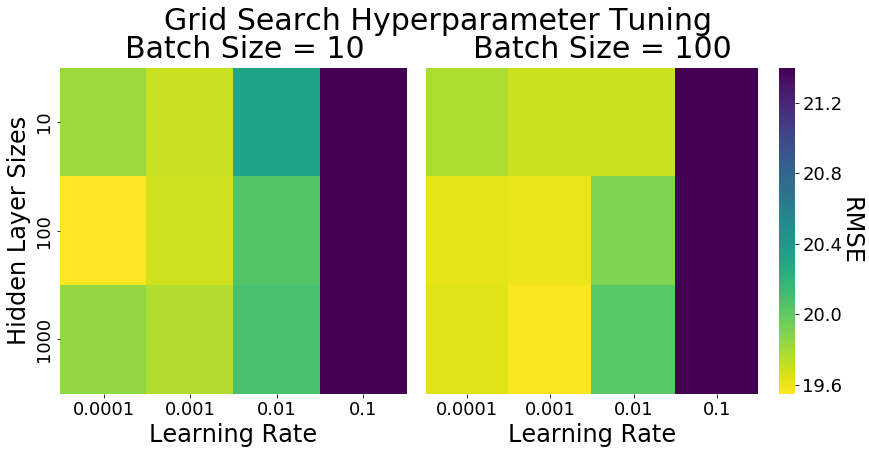

In [10]:
# 7hrs to run
fig, ax = plt.subplots(ncols=2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 1.2]})
ax1, ax2 = ax

vmin, vmax = results.losses.min(), 21.4#results.losses.max()

plt.suptitle('Grid Search Hyperparameter Tuning', fontsize=LARGE, x=0.5, y=1.02)
ax1.set_title('Batch Size = 10', fontsize=LARGE, x=0.532, y=1.01)
ax2.set_title('Batch Size = 100', fontsize=LARGE, x=0.532, y=1.01)

sns.heatmap(results[results.batch_size == 10].pivot(index='hidden_layer_sizes',  columns='learning_rate_init', values='losses'),
            ax=ax1, cmap='viridis_r', vmin=vmin, vmax=vmax, cbar=False)
sns.heatmap(results[results.batch_size == 100].pivot(index='hidden_layer_sizes', columns='learning_rate_init', values='losses'),
            ax=ax2, cmap='viridis_r', vmin=vmin, vmax=vmax)

cbar = ax2.collections[0].colorbar
cbar.set_label('RMSE', fontsize=MED, rotation=270, labelpad=20)

ax2.tick_params(left=False)
ax2.set_yticklabels([])
ax1.set_yticklabels([10, 100, 1000], va='center')
ax1.set_xlabel('Learning Rate', fontsize=MED)
ax1.set_ylabel('Hidden Layer Sizes', fontsize=MED)
ax2.set_xlabel('Learning Rate', fontsize=MED)
ax2.set_ylabel('')

plt.subplots_adjust(wspace=0.05, hspace=0)
plt.savefig('Grid Search Hyperparameter Tuning.png', dpi=fig.dpi*2, bbox_inches="tight")
plt.show()

In [ ]:
train_losses = []
val_losses = []

for max_iter in tqdm(range(2, 28, 2)):
    nn = MLPRegressor(hidden_layer_sizes=(100, 100), batch_size=10, learning_rate_init=0.0001, 
                      max_iter=max_iter, random_state=0)
    nn.fit(X_train_ohe, y_train.to_numpy())

    val_losses.append(RMSE(nn.predict(X_val_ohe), y_val))
    train_losses.append(RMSE(nn.predict(X_train_ohe), y_train))
    
    print(val_losses[-1], train_losses[-1])

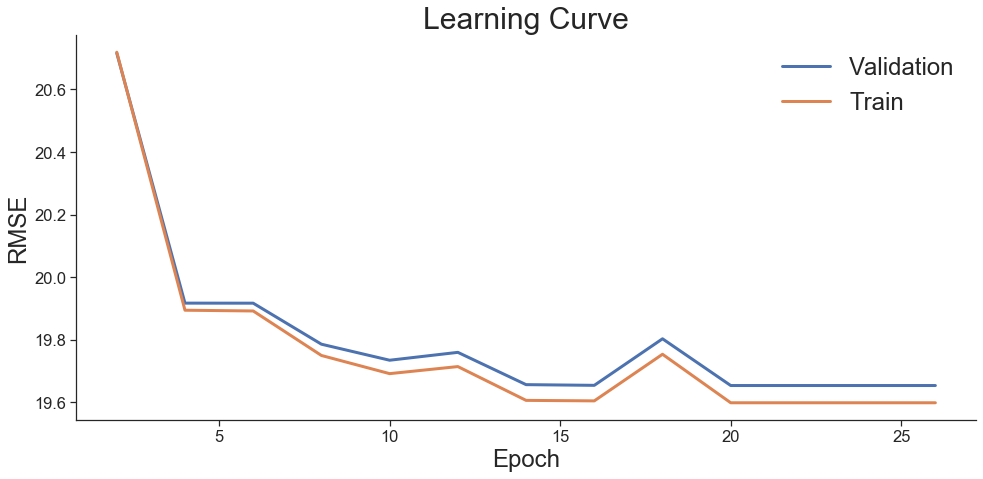

In [23]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot([i for i in range(2, 2*len(val_losses)+2, 2)], val_losses, lw=LW*1.5, label='Validation')
ax.plot([i for i in range(2, 2*len(val_losses)+2, 2)], train_losses, lw=LW*1.5, label='Train')

ax.set_title('Learning Curve', fontsize=LARGE)
ax.set_xlabel('Epoch', fontsize=MED)
ax.set_ylabel('RMSE', fontsize=MED)

sns.despine()
plt.legend(frameon=False, fontsize=MED)
plt.tight_layout()
plt.savefig('learning curve.png', dpi=fig.dpi*2, bbox_inches='tight')
plt.show()

# Test Data

In [62]:
# Baseline 1
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train_ohe, y_train)
dummy_train = RMSE(dummy.predict(X_train_ohe), y_train)
dummy_val   = RMSE(dummy.predict(X_val_ohe),   y_val)
dummy_test  = RMSE(dummy.predict(X_test_ohe),  y_test)
(dummy_train, dummy_val, dummy_test)

(22.49446523528733, 22.472478019134233, 22.507183062513672)

In [60]:
nn = MLPRegressor(hidden_layer_sizes=(100, 100), batch_size=10, learning_rate_init=0.0001, max_iter=20, random_state=0)
nn.fit(X_train_ohe, y_train.to_numpy())

MLPRegressor(activation='relu', alpha=0.0001, batch_size=10, beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100, 100), learning_rate='constant',
             learning_rate_init=1e-05, max_fun=15000, max_iter=20, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=0, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [61]:
nn_train = RMSE(nn.predict(X_train_ohe), y_train)
nn_val   = RMSE(nn.predict(X_val_ohe),   y_val)
nn_test  = RMSE(nn.predict(X_test_ohe),  y_test)
(nn_train, nn_val, nn_test)

(19.659800899582457, 19.715932671740102, 19.769718934694993)

In [63]:
lm = LinearRegression()
lm.fit(X_train_ohe, y_train)
lm_train = RMSE(lm.predict(X_train_ohe), y_train)
lm_val   = RMSE(lm.predict(X_val_ohe),   y_val)
lm_test  = RMSE(lm.predict(X_test_ohe),  y_test)
(lm_train, lm_val, lm_test)

(20.240434282533922, 20.21220241324288, 20.259907780639352)

In [15]:
#d, n, l = (dummy_train, dummy_val, dummy_test), (nn_train, nn_val, nn_test), (lm_train, lm_val, lm_test)
d, n, l = (22.49446523528733, 22.472478019134233, 22.507183062513672), (19.659800899582457, 19.715932671740102, 19.769718934694993), (20.240434282533922, 20.21220241324288, 20.259907780639352)

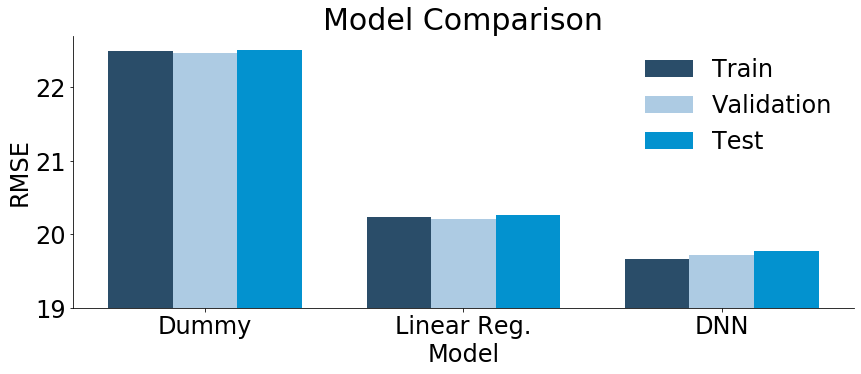

In [20]:
fig, ax = plt.subplots(figsize=(14, 5))

xs = np.arange(3)  # the label locations
width = 0.25  # the width of the bars

rmse_train = [d[0], l[0], n[0]]
rmse_val   = [d[1], l[1], n[1]]
rmse_test  = [d[2], l[2], n[2]]

ax.bar(xs - width, rmse_train,  width, label='Train', color='#2a4d69', edgecolor='none')
ax.bar(xs,         rmse_val,    width, label='Validation', color='#adcbe3', edgecolor='none')
ax.bar(xs + width, rmse_test,   width, label='Test', color='#0392cf', edgecolor='none')
ax.set_ylim(19, 22.7)

ax.set_ylabel('RMSE', fontsize=MED)
ax.set_xlabel('Model', fontsize=MED)
ax.set_title('Model Comparison', fontsize=LARGE)
ax.set_xticks(xs)
ax.set_xticklabels(['Dummy', 'Linear Reg.', 'DNN'], fontsize=MED)
ax.legend(frameon=False, fontsize=MED)
sns.despine()
plt.savefig('Model Comparison.png', dpi=fig.dpi*2, bbox_inches='tight')
plt.show()

In [94]:
d_yhat, l_yhat, n_yhat = np.e**dummy.predict(X_test_ohe), np.e**lm.predict(X_test_ohe), np.e**nn.predict(X_test_ohe)
actual = np.e**y_test.to_numpy()

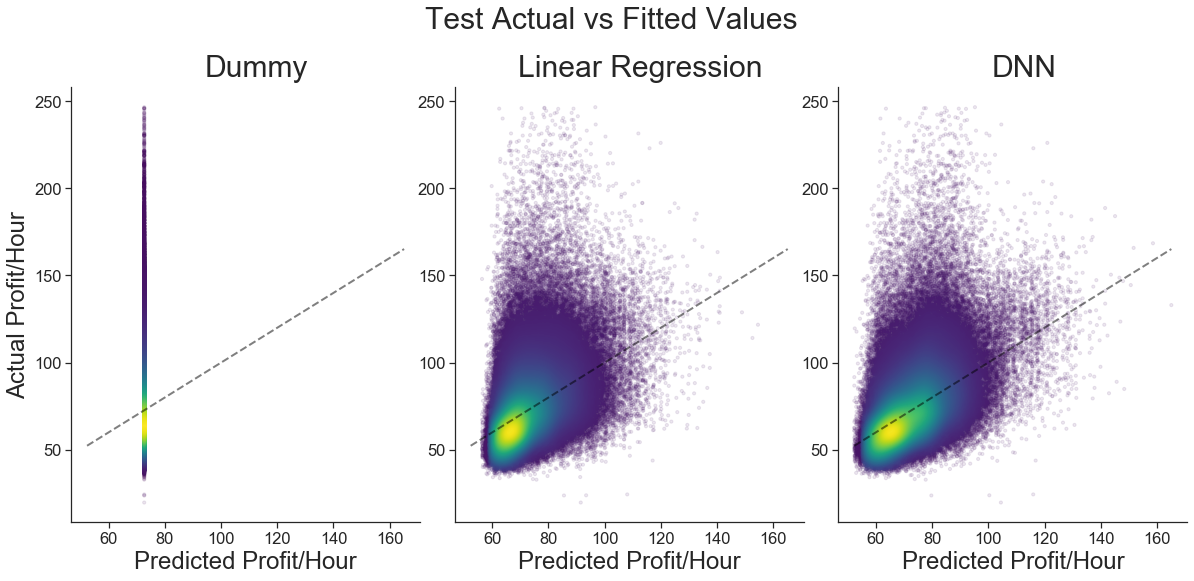

In [108]:
fig, ax = plt.subplots(ncols=3, figsize=(20, 8))
ax1, ax2, ax3 = ax
n = 200_000

plt.suptitle('Test Actual vs Fitted Values', fontsize=LARGE, x=0.5, y=1.02)
ax1.set_title('Dummy', fontsize=LARGE, x=0.532, y=1.01)
ax2.set_title('Linear Regression', fontsize=LARGE, x=0.532, y=1.01)
ax3.set_title('DNN', fontsize=LARGE, x=0.532, y=1.01)

x, y = d_yhat[:n], actual[:n]
data, x_e, y_e = np.histogram2d(x, y, bins=20, density=True)
z = interpn((0.5*(x_e[1:]+x_e[:-1]),0.5*(y_e[1:]+y_e[:-1])),data,np.vstack([x,y]).T,method="splinef2d",bounds_error=False)
z[np.where(np.isnan(z))] = 0.0
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]
ax1.scatter(x, y, c=z, s=10, cmap='viridis', alpha=0.1)

x, y = l_yhat[:n], actual[:n]
data, x_e, y_e = np.histogram2d(x, y, bins=20, density=True)
z = interpn((0.5*(x_e[1:]+x_e[:-1]),0.5*(y_e[1:]+y_e[:-1])),data,np.vstack([x,y]).T,method="splinef2d",bounds_error=False)
z[np.where(np.isnan(z))] = 0.0
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]
ax2.scatter(x, y, c=z, s=10, cmap='viridis', alpha=0.1)

x, y = n_yhat[:n], actual[:n]
data, x_e, y_e = np.histogram2d(x, y, bins=20, density=True)
z = interpn((0.5*(x_e[1:]+x_e[:-1]),0.5*(y_e[1:]+y_e[:-1])),data,np.vstack([x,y]).T,method="splinef2d",bounds_error=False)
z[np.where(np.isnan(z))] = 0.0
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]
ax3.scatter(x, y, c=z, s=10, cmap='viridis', alpha=0.1)

x = np.linspace(min(min(n_yhat), min(l_yhat)), max(max(n_yhat), max(l_yhat)))
for ax in ax1, ax2, ax3:
    ax.plot(x, x, lw=LW, c='black', linestyle='--', alpha=0.5)
    ax.set_xlabel('Predicted Profit/Hour', fontsize=MED)

ax1.set_ylabel('Actual Profit/Hour', fontsize=MED)

plt.subplots_adjust(wspace=0.1, hspace=0)
sns.despine()
plt.savefig('Test Results.png', dpi=fig.dpi*2, bbox_inches='tight')
plt.show()

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import shapefile
from descartes import PolygonPatch
import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm

SMALL, MED, LARGE = 22, 28, 34
LW = 3.5
plt.rc('xtick',labelsize=SMALL)
plt.rc('ytick',labelsize=SMALL)
MAX_MONTH = 6

zones = pd.read_csv('../Ass1/taxi-zones/taxi_zone_lookup.csv')

taxi = pd.read_pickle('../Ass1/taxi-data/yellow_tripdata_all.pkl')

taxi['year'] = taxi.tpep_pickup_datetime.dt.year
taxi['month'] = taxi.tpep_pickup_datetime.dt.month
taxi['week'] = taxi.tpep_pickup_datetime.dt.week
taxi['date'] = taxi.tpep_pickup_datetime.dt.date
taxi['day'] = taxi.tpep_pickup_datetime.dt.weekday
taxi['hour_float'] = taxi.tpep_pickup_datetime.dt.hour + taxi.tpep_pickup_datetime.dt.minute / 60
taxi['hour_int'] = taxi.tpep_pickup_datetime.dt.hour
taxi['tip_bool'] = np.where(taxi.tip_amount != 0, 1, 0)
taxi['av_speed'] = taxi.trip_distance / taxi.duration
taxi['tip_per'] = 100 * taxi.tip_amount / taxi.total_amount

# Vehicle type not recorded, so fuel consumption cannot be calculated, so ignoring that, we calculate profit
# Taxis do not get MTA commuters tax, improvement_surcharge also goes straight to paying for driver disability training,
# So not included in profit either. Congestion surcharge is also tax for trips that begin and end in NYC
# Extra column appears to be surcharges and other extras that are not for profit
taxi['profit'] = taxi.fare_amount + taxi.tip_amount

taxi['profitph'] = taxi.profit / taxi.duration

taxi20 = taxi[taxi.year == 2020]

263it [00:01, 248.70it/s]


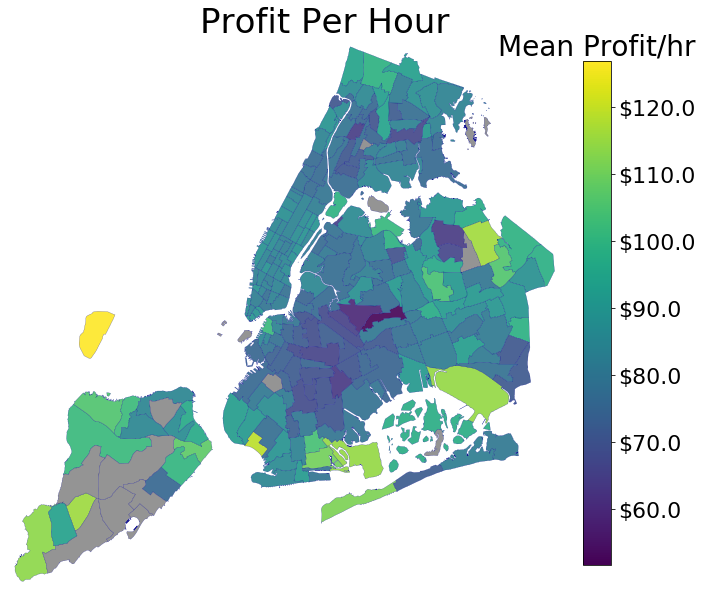

In [10]:
taxiMean20 = taxi[(taxi.month.isin([4, 5, 6])) & (taxi.year == 2020)].groupby('PULocationID').mean().reset_index()

locs = shapefile.Reader('../Ass1/taxi-zones/taxi_zones.shp')

# JFK HAS BECOME WAY MORE PROFITABLE SINCE LESS TRAFFIC - TRIPS AT FLAT FARE ARE NOW QUICKER
fig, ax = plt.subplots(figsize=(10, 10))

for loc_id, loc in tqdm(enumerate(locs.iterShapes())):
    BLUE, GREY = '#00008B', '#888888'
    
    loc_id += 1
    loc = loc.__geo_interface__
    
    norm = matplotlib.colors.Normalize(vmin=taxiMean20.profitph.min(), 
                                       vmax=taxiMean20.profitph.max(), clip=True)
    mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis)
    
    # 2020
    if loc_id not in taxiMean20.PULocationID.unique():
        col = GREY

    else:
        count = taxiMean20[taxiMean20.PULocationID == loc_id].profitph.to_list()[0]

        col = mcolors.to_hex(mapper.to_rgba(count))

    ax.add_patch(PolygonPatch(loc, fc=col, ec=BLUE, alpha=0.9, zorder=10, linewidth=0.2))
    ax.axis('scaled')

ax.set_title('Profit Per Hour'.rjust(23), fontsize=LARGE)
ax.set_xticks([]); ax.set_yticks([])
ax.set_ylim(119_700, 275_000), ax.set_xlim(911_000, 1_068_000)

ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False); ax.spines['left'].set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

left, bottom, width, height = 0.93, 0.15, 0.04, 0.7
cbar_ax = fig.add_axes([left, bottom, width, height])
fig.colorbar(mapper, cax=cbar_ax, orientation='vertical', cmap='viridis')
cbar_ax.set_title('Mean Profit/hr', fontsize=MED)

import matplotlib.ticker as mtick
fmt = '${x}'
tick = mtick.StrMethodFormatter(fmt)
cbar_ax.yaxis.set_major_formatter(tick) 

plt.savefig('map.png', dpi=fig.dpi*2, bbox_inches='tight')
plt.show()